In [1]:
import stability_functions as sf
import numpy as np
import rebound
import numpy.random as rd
import radvel
import corner
import copy
import scipy
import pandas as pd
from scipy import optimize
from radvel.plot import orbit_plots
import sys
# # plotting
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('paper.mplstyle')
# # %matplotlib inline

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/radvel/gp.py:33: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  Try installing celerite using 'pip install celerite'", ImportWarning)


In [3]:
systems = ["HR858", "K431", "TOI270", "L98-59", "K23"]
system = systems[4]
# system = systems[int(sys.argv[1])]
sf.valid_system(system)
sim_names = system + "/" + system
systems_ran = 256

df = pd.read_csv(sim_names + ".csv", index_col=0)
df = df.sort_values("probstability", ascending=False)
nsim_l = np.array(df.iloc[0:(systems_ran - 1)]["sim"]).astype(int)

df1 = pd.DataFrame(data=nsim_l, columns=["sim"])
df1 = df1.set_index("sim")
df1["stable"] = False
for nsim in nsim_l:
    try:
        df2 = pd.read_csv(sim_names + "_%d_orbits.csv"%nsim, index_col=0)
        df1.stable[nsim] = df2["stable"][0]
    except:
        df1.stable[nsim] = False

stable_sims = np.array(df1[df1.stable == True].index).astype(int)

e_df = df.loc[stable_sims]
e_df["total e"] = e_df["e1"] + e_df["e2"] + e_df["e3"]
e_df = e_df.sort_values("total e")
sim_nums = np.array(e_df["sim"]).astype(int)

In [4]:
# std_out_holder = sys.__stdout__

def myPriorFunc(inp_list):
    return sf.myPriorFunc(labels, Mstar, prior_ms_small, prior_es_small, inp_list)

fig_name = "figs/" + system + "_"

sim_num = sim_nums[0]
name = sim_names+"_sa_"+str(sim_num)+".bin"

print("simulation archive:", name)
sim = rebound.SimulationArchive(name)[0]

n_meas = 50
t_rb = 0.75 * np.sort(rd.rand(n_meas))
syn_rv_base = sf.rebound_rvs(t_rb, rebound.SimulationArchive(name)[0])
ti_rb = np.linspace(np.min(t_rb), np.max(t_rb), 1000)
syn_rv_no_noise = sf.rebound_rvs(ti_rb, rebound.SimulationArchive(name)[0])
t = t_rb * sf.days_p_year
ti = ti_rb * sf.days_p_year

errs = np.array([30, 10, 3, 1, 0.3, 0.1])
jitter = 0.0
stellar = jitter * rd.randn(n_meas)

print("jitter value:", jitter)

Ps = np.array([sim.particles[i+1].P for i in range(3)]) * (sf.days_p_year * sf.year_p_reboundtime)
es = np.array([sim.particles[i+1].e for i in range(3)])
Mstar = sim.particles[0].m
ms = np.array([sim.particles[i+1].m for i in range(3)]) * sf.earth_mass_p_solar_mass
incs = np.array([sim.particles[i+1].inc for i in range(3)]) + np.pi/2
og_Ks = sf.VSA(Ps / sf.days_p_year, Mstar, ms, es, incs)
Ks = np.copy(og_Ks)

omegas = np.array([sim.particles[i+1].omega for i in range(3)])
print("og Ks:", og_Ks)
print("initial Ks:", Ks)

truths = list(es)
truths.extend([sim.particles[i+1].m * sf.earth_mass_p_solar_mass for i in range(3)])
    
labels_base = ["e1","e2", "e3", "m1", "m2", "m3"]
labels2 = [r"$e_1$", r"$e_2$", r"$e_3$", r"$m_1$", r"$m_2$", r"$m_3$"]

err_ind = 2
# err_ind = int(sys.argv[2])

simulation archive: HR858/HR858_sa_5834.bin
jitter value: 0.0
og Ks: [1.51487047 0.61516983 1.7543059 ]
initial Ks: [1.51487047 0.61516983 1.7543059 ]


working on err_ind 2

with an error value of 3.000000 m/s

parameter                     value      vary
per1                        3.58612       True
tc1                         8409.19       True
secosw1                 0.000417158       True
sesinw1                   0.0596401       True
k1                          1.51487       True
per2                        5.97285       True
tc2                         8415.63       True
secosw2                   0.0752872       True
sesinw2                  -0.0324652       True
k2                          0.61517       True
per3                        11.2299       True
tc3                         8409.73       True
secosw3                  -0.0614814       True
sesinw3                   0.0354529       True
k3                          1.75431       True
dvdt                              0      False
curv                              0      False
gamma                             0      False
jit                               0      False
 


No handles with labels found to put in legend.


After fitting

parameter                     value      vary
per1                        3.58591       True
tc1                         8409.19       True
secosw1                 0.000417158       True
sesinw1                   0.0596401       True
k1                          1.51487       True
per2                        5.97287       True
tc2                         8415.63       True
secosw2                   0.0752872       True
sesinw2                  -0.0324652       True
k2                          0.61517       True
per3                        11.2299       True
tc3                         8409.73       True
secosw3                  -0.0614814       True
sesinw3                   0.0354529       True
k3                          1.75431       True
dvdt                              0      False
curv                              0      False
gamma                             0      False
jit                               0      False

Priors
------
Gaussian prior on per1, mu=3.58

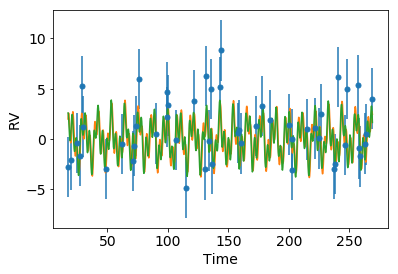

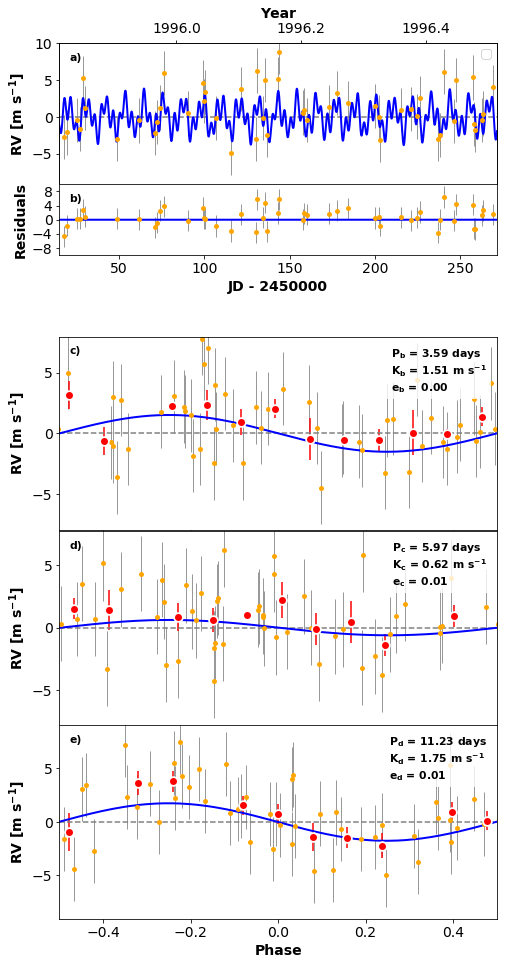

In [8]:
# %%time
# for err_ind in range(len(errs)):
# for err_ind in range(1):
# #     sys.stdout = open(fig_name + "%d_notes.txt"%err_ind, "w")
errval = errs[err_ind]

print("working on err_ind %d\n"%err_ind)
print("with an error value of %f m/s\n"%errval)

syn_rv = syn_rv_base + rd.randn(n_meas) * errval + stellar

params = radvel.Parameters(3, basis='per tc secosw sesinw k')
params['per1'] = radvel.Parameter(value=Ps[0])
params['tc1'] = radvel.Parameter(value= 2458409.18969)
params['secosw1'] = radvel.Parameter(value=np.sqrt(es[0]) * np.cos(omegas[0]))
params['sesinw1'] = radvel.Parameter(value=np.sqrt(es[0]) * np.sin(omegas[0]))
params['k1'] = radvel.Parameter(value=Ks[0])

params['per2'] = radvel.Parameter(value=Ps[1])
params['tc2'] = radvel.Parameter(value=2458415.6344)
params['secosw2'] = radvel.Parameter(value=np.sqrt(es[1]) * np.cos(omegas[1]))
params['sesinw2'] = radvel.Parameter(value=np.sqrt(es[1]) * np.sin(omegas[1]))
params['k2'] = radvel.Parameter(value=Ks[1])

params['per3'] = radvel.Parameter(value=Ps[2])
params['tc3'] = radvel.Parameter(value=2458409.7328)
params['secosw3'] = radvel.Parameter(value=np.sqrt(es[2]) * np.cos(omegas[2]))
params['sesinw3'] = radvel.Parameter(value=np.sqrt(es[2]) * np.sin(omegas[2]))
params['k3'] = radvel.Parameter(value=Ks[2])

# params['dvdt'] = radvel.Parameter(value=0)
# params['curv'] = radvel.Parameter(value=0)

rv_mod = radvel.RVModel(params)

like_syn = radvel.likelihood.RVLikelihood(rv_mod, t, syn_rv, np.zeros(t.size)+errval)
like_syn.params['gamma'] = radvel.Parameter(value=0)
like_syn.params['jit'] = radvel.Parameter(value=jitter)

like_syn.params['jit'].vary = False # Don't vary jitter
# like_syn.params['k1'].vary = False # Don't vary period
# like_syn.params['k2'].vary = False # Don't vary period
# like_syn.params['k3'].vary = False # Don't vary period
# like_syn.params['per1'].vary = False # Don't vary period
# like_syn.params['per2'].vary = False # Don't vary period
# like_syn.params['per3'].vary = False # Don't vary period
like_syn.params['dvdt'].vary = False # Don't vary dvdt
like_syn.params['curv'].vary = False # Don't vary curvature
like_syn.params['gamma'].vary = False # Don't vary gamma
print(like_syn, "\n")

# Plot initial model
sf.plot_radvel_results(like_syn, t)
plt.plot(ti, syn_rv_no_noise)
plt.savefig(fig_name + "%d_beforeMLE.png"%err_ind, bbox_inches="tight")
plt.close(fig="all")

res  = optimize.minimize(like_syn.neglogprob_array, like_syn.get_vary_params(), method='L-BFGS-B')
# print(res)
print(like_syn, "\n")
sf.plot_radvel_results(like_syn, t) # plot best fit model
plt.plot(ti, syn_rv_no_noise)
plt.savefig(fig_name + "%d_afterMLE.png"%err_ind, bbox_inches="tight")

post = radvel.posterior.Posterior(like_syn)

if system == "HR858":
    post.priors += [radvel.prior.Gaussian("per1", 3.58599, 0.00015)]
    post.priors += [radvel.prior.Gaussian("per2", 5.97293, 0.00057)]
    post.priors += [radvel.prior.Gaussian("per3", 11.2300, 0.0011)]

if system == "K431":
    post.priors += [radvel.prior.Gaussian("per1", 6.80252171, 7.931e-05)]
    post.priors += [radvel.prior.Gaussian("per2", 8.70337044, 9.645e-05)]
    post.priors += [radvel.prior.Gaussian("per3", 11.9216214, 0.0001182)]

if system == "TOI270":
    post.priors += [radvel.prior.Gaussian("per1", 3.36008, 0.000068)]
    post.priors += [radvel.prior.Gaussian("per2", 5.660172, 0.000035)]
    post.priors += [radvel.prior.Gaussian("per3", 11.38014, 0.00011)]

if system == "L98-59":
    post.priors += [radvel.prior.Gaussian("per1", 2.25314, 0.00002)]
    post.priors += [radvel.prior.Gaussian("per2", 3.690621, 0.0000135)]
    post.priors += [radvel.prior.Gaussian("per3", 7.45086, 0.000045)]
    
#Holczer et al. 2016
if system == "K23":
    post.priors += [radvel.prior.Gaussian("per1", 7.10697755, 0.00001048)]
    post.priors += [radvel.prior.Gaussian("per2", 10.74244253, 0.00000349)]
    post.priors += [radvel.prior.Gaussian("per3", 15.27458613, 0.00000510)]
        
labels = [k for k in post.params.keys() if post.params[k].vary]

prior_ms = [scipy.stats.gaussian_kde(df["m1"]), scipy.stats.gaussian_kde(df["m2"]), scipy.stats.gaussian_kde(df["m3"])]
prior_es = [scipy.stats.gaussian_kde(df["e1"]), scipy.stats.gaussian_kde(df["e2"]), scipy.stats.gaussian_kde(df["e3"])]

inds = np.sort(np.random.choice(range(len(df)), size=4000, replace=False))
prior_ms_small = [scipy.stats.gaussian_kde(df["m1"][inds]), scipy.stats.gaussian_kde(df["m2"][inds]), scipy.stats.gaussian_kde(df["m3"][inds])]
prior_es_small = [scipy.stats.gaussian_kde(df["e1"][inds]), scipy.stats.gaussian_kde(df["e2"][inds]), scipy.stats.gaussian_kde(df["e3"][inds])]

post.priors += [radvel.prior.UserDefinedPrior(labels, myPriorFunc, 'Eccentricty and mass prior')]
# post.priors += [radvel.prior.EccentricityPrior(3)]

print("Before fitting\n")
print(post, "\n")

# res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='L-BFGS-B')
# sf.plot_radvel_results(post.likelihood, t)
plt.savefig(fig_name + "%d_afterpriors.png"%err_ind, bbox_inches="tight")
print("After fitting\n")
print(post, "\n")

RVPlot = orbit_plots.MultipanelPlot(post)
RVPlot.plot_multipanel()
# plt.show()
plt.savefig(fig_name + "%d_afterpriors_multi.png"%err_ind, bbox_inches="tight")
# plt.close(fig="all")

# df = radvel.mcmc(post) # amount of steps = nrun * 8 * nwalkers ?
#     df3 = radvel.mcmc(post, nrun=10000) # amount of steps = nrun * 8 * nwalkers ?, default nrun is 10000, default nwalkers is 50?
df3 = radvel.mcmc(post, nrun=1000) # amount of steps = nrun * 8 * nwalkers ?, default nrun is 10000, default nwalkers is 50?
df3.to_pickle(fig_name + "%d_mcmc.pkl"%err_ind)

working on m1



std before: 3.937706

std after: 1.791309

factor of 2.198228 smaller

"sigma" before: 3.169542

"sigma" after: 1.884842

factor of 1.681595 smaller

Gaussian fit std before:  2.5461340372545145 

Gaussian fit std after:  1.9537830281188449 

factor of 1.303182 smaller

working on m2



std before: 3.464503

std after: 1.625818

factor of 2.130930 smaller

"sigma" before: 2.713241

"sigma" after: 1.636028

factor of 1.658432 smaller

Gaussian fit std before:  2.1658062668671434 

Gaussian fit std after:  1.8337996957575904 

factor of 1.181048 smaller

working on m3



std before: 4.163253

std after: 2.991855

factor of 1.391529 smaller

"sigma" before: 3.289640

"sigma" after: 3.114000

factor of 1.056403 smaller

Gaussian fit std before:  2.6756412706319277 

Gaussian fit std after:  -3.241049431552798 

factor of -0.825548 smaller

working on m1+m2



std before: 5.243266

std after: 2.213900

factor of 2.368339 smaller

"sigma" before: 4.580844

"sigma" after: 2.2

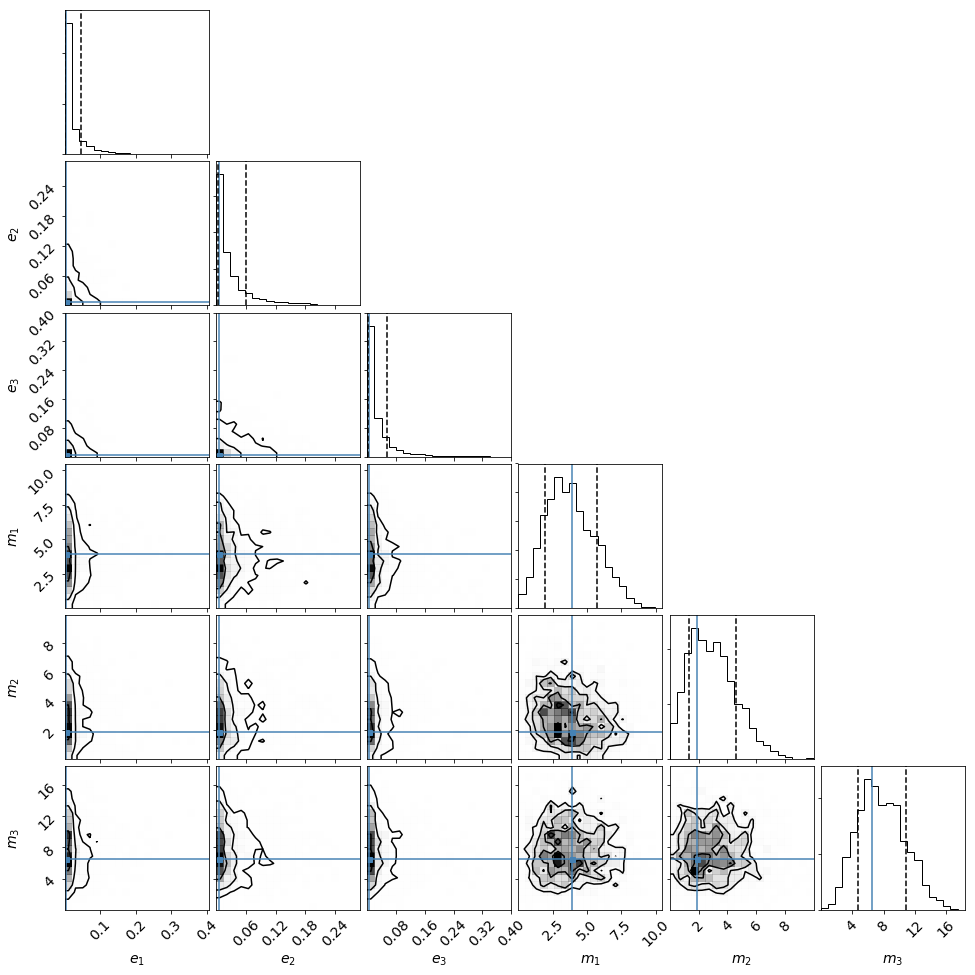

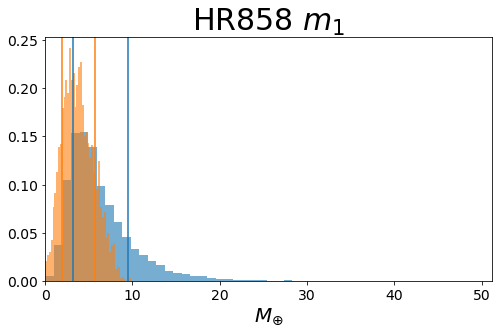

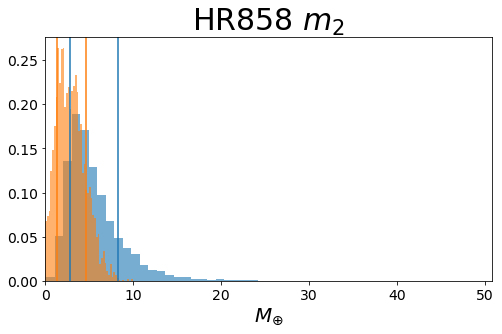

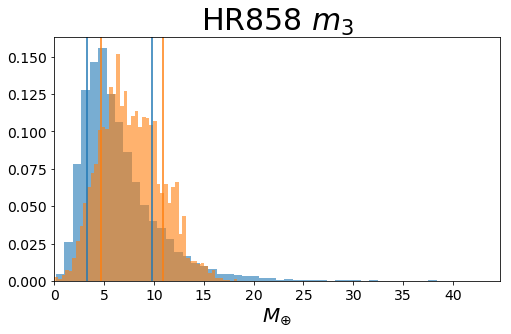

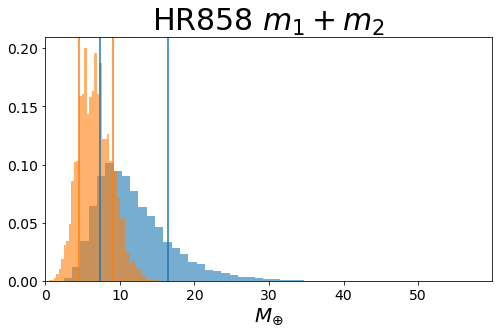

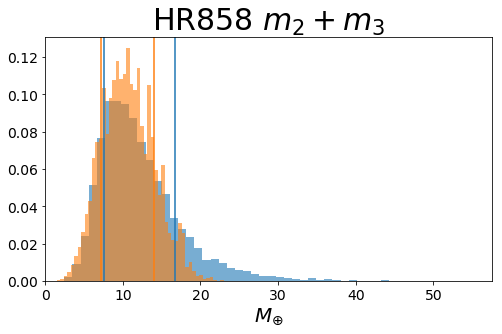

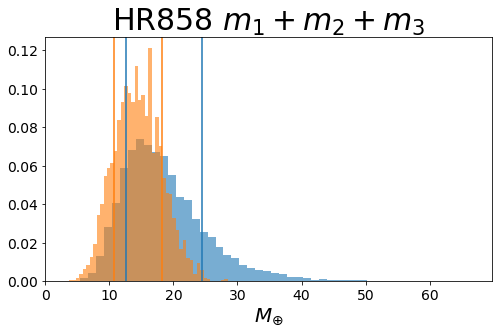

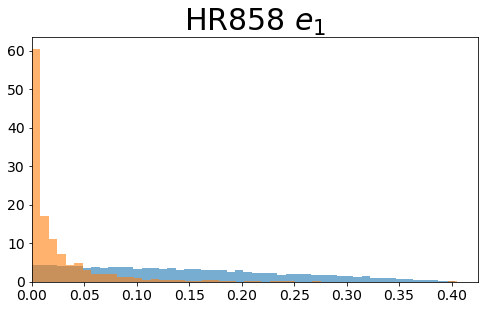

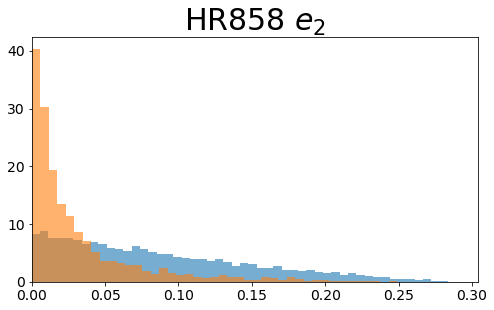

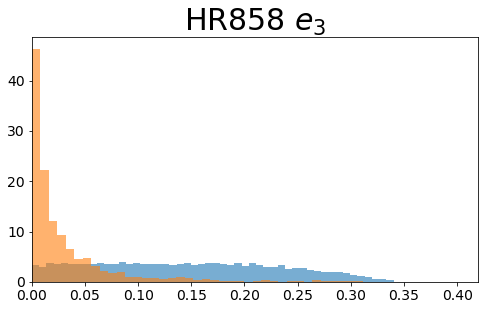

In [10]:
df2 = pd.read_pickle(fig_name + "%d_mcmc.pkl"%err_ind)
# fig = corner.corner(df3[labels], labels=labels, quantiles=[0.16,0.84], plot_datapoints=False)
# plt.savefig("figs/corner_K431_%d.png"%err_ind, bbox_inches="tight")

# df2 = df3.copy()
for i in range(1,4):
    df2["e%d"%i] = df2["secosw%d"%i] * df2["secosw%d"%i] + df2["sesinw%d"%i] * df2["sesinw%d"%i]
    df2["m%d"%i] = sf.mass_from_VSA(df2["per%d"%i] / sf.days_p_year, Mstar, df2["k%d"%i].abs(), df2["e%d"%i], np.pi/2)
df2 = df2[labels_base]

fig = corner.corner(df2, labels=labels2, truths=truths, quantiles=[0.16,0.84], plot_datapoints=False)
plt.savefig(fig_name + "%d_physical_corner.png"%err_ind, bbox_inches="tight")

df2["m1+m2"] = df2["m1"] + df2["m2"]
df2["m2+m3"] = df2["m2"] + df2["m3"]
df2["total m"] = df2["m1"] + df2["m2"] + df2["m3"]

sf.create_mcmc_hist(system, err_ind, df, df2, "m1", label2=r"$m_1$", xlabel=r"$M_{\oplus}$")
sf.create_mcmc_hist(system, err_ind, df, df2, "m2", label2=r"$m_2$", xlabel=r"$M_{\oplus}$")
sf.create_mcmc_hist(system, err_ind, df, df2, "m3", label2=r"$m_3$", xlabel=r"$M_{\oplus}$")

sf.create_mcmc_hist(system, err_ind, df, df2, "m1+m2", label2=r"$m_1 + m_2$", xlabel=r"$M_{\oplus}$")
sf.create_mcmc_hist(system, err_ind, df, df2, "m2+m3", label2=r"$m_2 + m_3$", xlabel=r"$M_{\oplus}$")
sf.create_mcmc_hist(system, err_ind, df, df2, "total m", label2=r"$m_1 + m_2 + m_3$", xlabel=r"$M_{\oplus}$")

#     xs = np.linspace(0,1,1000)
sf.create_mcmc_hist(system, err_ind, df, df2, "e1", show_quantiles=False, label2=r"$e_1$")
sf.create_mcmc_hist(system, err_ind, df, df2, "e2", show_quantiles=False, label2=r"$e_2$")
sf.create_mcmc_hist(system, err_ind, df, df2, "e3", show_quantiles=False, label2=r"$e_3$")
    
#     sys.stdout.close()

# sys.stdout = std_out_holder

In [5]:
df4 = pd.read_pickle(fig_name + "%d_mcmc.pkl"%err_ind)

In [6]:
df4

,per1,tc1,secosw1,sesinw1,k1,per2,tc2,secosw2,sesinw2,k2,per3,tc3,secosw3,sesinw3,k3,lnprobability
0,3.590706,2.458409e+06,0.000444,0.062608,1.580110,5.948166,2.458416e+06,0.079471,-0.029901,0.633248,11.230692,2.458410e+06,-0.056939,0.036069,1.785040,-1547.774972
1,3.590706,2.458409e+06,0.000411,0.066339,1.726157,5.948198,2.458416e+06,0.086009,-0.031291,0.681140,11.230667,2.458410e+06,-0.060736,0.038494,1.935771,-1551.205268
2,3.590691,2.458409e+06,0.000449,0.061963,1.596729,5.948150,2.458416e+06,0.079565,-0.031265,0.614911,11.230724,2.458410e+06,-0.061138,0.039019,1.781803,-1551.205268
3,3.590701,2.458409e+06,0.000451,0.062584,1.616444,5.948162,2.458416e+06,0.081690,-0.032337,0.632215,11.230725,2.458410e+06,-0.060636,0.036516,1.823567,-1557.506072
4,3.590707,2.458409e+06,0.000445,0.064721,1.583969,5.948154,2.458416e+06,0.076128,-0.029277,0.636457,11.230682,2.458410e+06,-0.056251,0.038465,1.825459,-1557.506072
5,3.590692,2.458409e+06,0.000421,0.064895,1.567545,5.948186,2.458416e+06,0.081219,-0.029357,0.663373,11.230728,2.458410e+06,-0.061023,0.036708,1.800491,-1557.506072
6,3.590707,2.458409e+06,0.000434,0.060414,1.548251,5.948183,2.458416e+06,0.082233,-0.030681,0.654869,11.230658,2.458410e+06,-0.057580,0.037519,1.912450,-1557.506072
7,3.590705,2.458409e+06,0.000451,0.064570,1.641092,5.948155,2.458416e+06,0.080806,-0.030046,0.641020,11.230755,2.458410e+06,-0.061209,0.038515,1.746405,-1554.516530
8,3.590710,2.458409e+06,0.000442,0.065077,1.533932,5.948160,2.458416e+06,0.081924,-0.030499,0.601951,11.230687,2.458410e+06,-0.054743,0.035149,1.761898,-1544.875581
9,3.590706,2.458409e+06,0.000411,0.066339,1.726157,5.948198,2.458416e+06,0.086009,-0.031291,0.681140,11.230667,2.458410e+06,-0.060736,0.038494,1.935771,-1544.875581
